In [1]:
import LLMSR
import openai

import numpy as np
import matplotlib.pyplot as plt

In [2]:
client = openai.OpenAI(
  base_url="https://openrouter.ai/api/v1",
  api_key="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",
)

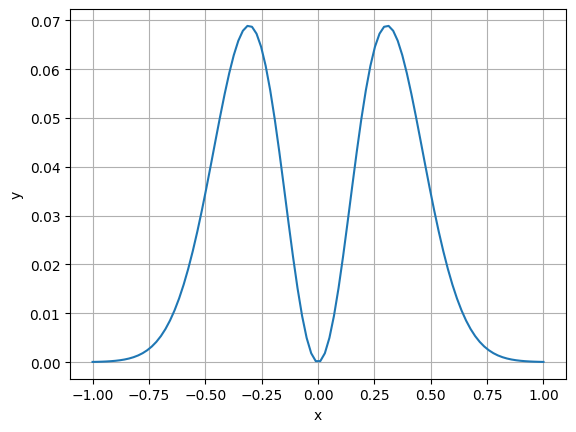

In [3]:
x = np.linspace(-1, 1, 100)
y = x*np.sin(2*x)*np.exp(-10 * x**2)
#y = np.tanh(3*x)

plt.plot(x, y,label='data')
plt.xlabel('x')
plt.ylabel('y')
plt.grid(True)
#plt.legend()
plt.savefig('plot.png')

# Getting the Base64 string
base64_image = LLMSR.encode_image('plot.png')

In [4]:
r = LLMSR.single_call(client, base64_image, x, y, model="openai/gpt-4o-mini",function_list=None, system_prompt=None)
print(r)

{'params': array([ 4.47338400e-02,  2.05212461e+00, -3.55526478e-07]), 'score': np.float64(-0.011960289422096853), 'ansatz': ' params[0] * np.exp(-params[1] * (x - params[2]) ** 2)', 'Num_params': 3, 'response': ChatCompletion(id='gen-1739985201-JsmelU2bhxyvfdVWbaVg', choices=[Choice(finish_reason='stop', index=0, logprobs=None, message=ChatCompletionMessage(content='```python\ncurve_1 = lambda x, *params: params[0] * np.exp(-params[1] * (x - params[2]) ** 2)\n```', refusal=None, role='assistant', audio=None, function_call=None, tool_calls=None), native_finish_reason='stop')], created=1739985201, model='openai/gpt-4o-mini', object='chat.completion', service_tier=None, system_fingerprint='fp_13eed4fce1', usage=CompletionUsage(completion_tokens=39, prompt_tokens=664, total_tokens=703, completion_tokens_details=None, prompt_tokens_details=None), provider='OpenAI'), 'prompt': 'import numpy as np \ncurve_0 = lambda x,*params: x* params[0] + params[1] \ncurve_1 = lambda x,*params:', 'functio

pop_size = 10 and num_of_generations = 5 will cost about $0.10 on 4o-mini

In [5]:
population_size = 10
num_of_generations = 5
start = LLMSR.check_key_limit(client)
res = LLMSR.run_genetic(client, base64_image, x, y, population_size,num_of_generations, 
                        temperature=1., model="openai/gpt-4o", system_prompt=None, elite=False)
print(f"Credits spent: {start - LLMSR.check_key_limit(client)}")

Generating Initial population population


100%|██████████| 10/10 [01:05<00:00,  6.54s/it]


Best score:  -0.009986009522942589
Best ansatz:   params[0] * np.exp(-((x - params[1]) ** 2) / (2 * params[2] ** 2)) * np.sin(params[3] * x + params[4])
Best params:  [ 4.47272456e-02 -1.61620398e+00  2.84046081e+02  1.73150136e+00
  1.57079182e+00]
Generation: 1


 40%|████      | 4/10 [05:32<12:49, 128.27s/it]/Users/trharvey/llm/lib/python3.13/site-packages/LLMSR/llmSR.py:88: OptimizeWarning: Covariance of the parameters could not be estimated
  params_opt, _ = curve_fit(curve, x, y, p0=params_initial)
100%|██████████| 10/10 [06:00<00:00, 36.05s/it]


Best score:  -0.00998569742532882
Best ansatz:   np.exp(-((x - params[0]) ** 2) / (2 * params[1] ** 2)) * params[2] * np.cos(params[3] * x)
Best params:  [1.12630568e+00 2.38623881e+02 4.47287252e-02 1.73150109e+00]
Generation: 2


100%|██████████| 10/10 [00:32<00:00,  3.26s/it]


Best score:  -1.2814771291978166e-10
Best ansatz:   params[0] * np.exp(-((x - params[1]) ** 2) / (2 * params[2] ** 2)) * np.sin(params[3] * x)**2 + params[4]
Best params:  [ 6.91596076e-01 -1.29446142e-08 -2.27014173e-01 -1.70053388e+00
 -5.32917460e-07]
Exit condition met.
Credits spent: 0.32118549999999857


In [6]:
len(res[0])

10

In [7]:
highest_score_element = max((item for sublist in res for item in sublist), key=lambda item: item['score'])
print(highest_score_element['ansatz'])

 params[0] * np.exp(-((x - params[1]) ** 2) / (2 * params[2] ** 2)) * np.sin(params[3] * x)**2 + params[4]


In [10]:
print(highest_score_element['function_list'])

[' params[0] * np.exp(-((x - params[1]) ** 2) / (2 * params[2] ** 2)) * np.sin(params[3] * x + params[4]) + params[5]', ' np.exp(-((x - params[0]) ** 2) / (2 * params[1] ** 2)) * np.cos(params[2] * x + params[3])']


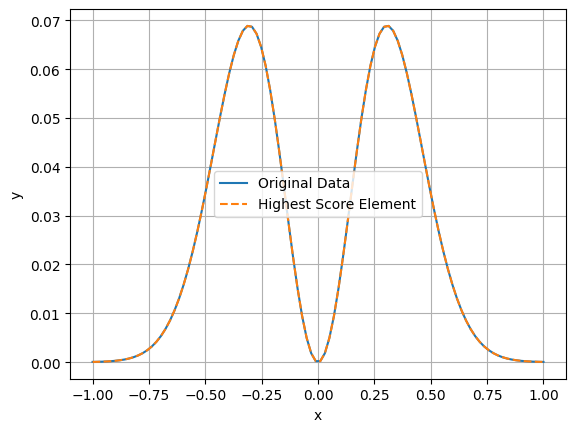

In [8]:
# Extract the parameters and the ansatz function from the highest_score_element
params = highest_score_element['params']
ansatz = highest_score_element['ansatz']

# Define the ansatz function
def ansatz_function(x, params):
    return eval(ansatz)

# Plot the original data
plt.plot(x, y, label='Original Data')

# Plot the highest score element
plt.plot(x, ansatz_function(x, params), label='Highest Score Element', linestyle='--')

# Add labels and legend
plt.xlabel('x')
plt.ylabel('y')
plt.legend()
plt.grid(True)
plt.show()

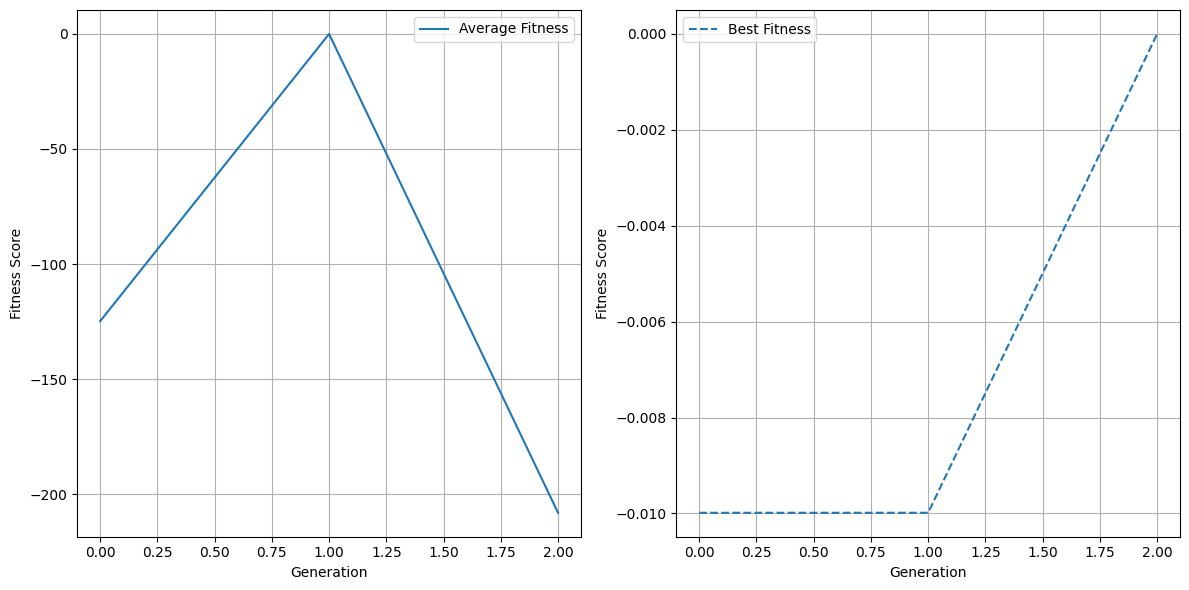

In [12]:
# Remove infinite scores
filtered_res = [[ind for ind in generation if np.isfinite(ind['score'])] for generation in res]

# Extract fitness scores from the filtered results
average_fitness = [np.mean([ind['score'] for ind in generation]) for generation in filtered_res]
best_fitness = [max([ind['score'] for ind in generation]) for generation in filtered_res]

# Create subplots
fig, axs = plt.subplots(1, 2, figsize=(12, 6))

# Plot the average fitness
axs[0].plot(range(len(average_fitness)), average_fitness, label='Average Fitness')
axs[0].set_xlabel('Generation')
axs[0].set_ylabel('Fitness Score')
axs[0].legend()
axs[0].grid(True)

# Plot the best fitness
axs[1].plot(range(len(average_fitness)), best_fitness, label='Best Fitness', linestyle='--')
axs[1].set_xlabel('Generation')
axs[1].set_ylabel('Fitness Score')
axs[1].legend()
axs[1].grid(True)

# Show the plots
plt.tight_layout()
plt.show()